In [1]:
#import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
# Load the dataframe, and clean the lists that were stored as text in the csv file
df = pd.read_csv(r'C:\Users\MainUser\Desktop\Quotes_Cleaned.csv')
df['words'] = df.words.apply(lambda x: x.strip('[]').split(','))
df['words_ex_stopwords'] = df.words_ex_stopwords.apply(lambda x: x.strip('[]').split(','))
df['lemmas'] = df.lemmas.apply(lambda x: x.strip('[]').split(','))

In [4]:
# Define the vocabulary list for the bag of words model. 
vocabulary = []
for lemmas_list in df['lemmas']:
    for word in lemmas_list:
        if word.strip()[1:-1] not in vocabulary:
            vocabulary.append(word.strip()[1:-1])

In [5]:
# A function for our pipeline to define the feature columns and split the data into training and test sets
def split(df):
    '''
    Extracts training and testing data from a dataframe
    '''    
    y = df['Author']
    X = df[['lemmas_text','sentence_length','stop_word_pct']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
    return  X_train, X_test, y_train, y_test

In [6]:
# A function for our pipeline to vectorize the lemmas text column
def vectorize_bow(vocabulary, X_train, X_test):
    '''
    (1) Vectorizes the lemma text into a sparse matrix bag of words (BOW) using tf-idf
    (2) Adds the Non-BOW features to the sparse matrix for training data
    (3) Adds the Non-BOW features to the sparse matrix for test data
    (4) Returs X_train & X_test with vectorized BOW
    '''
    
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['lemmas_text'])
    X_test_tfidf = tfidf_vectorizer.transform(X_test['lemmas_text'])

    sent_len_train = np.array(X_train['sentence_length'])[:,None]
    stop_words_train = np.array(X_train['stop_word_pct'])[:,None]
    X_train_sparse = sparse.hstack((X_train_tfidf,sent_len_train,stop_words_train))

    sent_len_test = np.array(X_test['sentence_length'])[:,None]
    stop_words_test = np.array(X_test['stop_word_pct'])[:,None]
    X_test_sparse = sparse.hstack((X_test_tfidf,sent_len_test,stop_words_test))

    return X_train_sparse, X_test_sparse, tfidf_vectorizer


In [7]:
# A function for our pipeline to train the logistic regression model and return predicted y values
def logreg_train(X_train, X_test, y_train):
    '''
    Trains and fits the logistic regression model, using an L2 regularization and a liblinear solver, using a grid search
    over [0.001, 0.01, 0.1, 1, 10, 100, 1000] to solve for C. Returns the predictions as well as the best model and the best
    parameter found in the grid search. 
    '''
    model = LogisticRegression(penalty='l2', fit_intercept=True, solver='liblinear')
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid = GridSearchCV(model, cv=10, n_jobs=-1, param_grid=param_grid, scoring='accuracy', refit=True)
    grid.fit(X_train, y_train)
    y_predict = grid.predict(X_test)
    
    return y_predict, grid.best_estimator_, grid.best_params_

In [32]:
# A function for our pipeline to train the Naive Bayes model and return predicted y values
def NB_train(X_train, X_test, y_train):
    '''
    Trains and fits the Multinomial Naive Bayes model, using a grid search
    over [0.001, 0.01, 0.1, 1] to solve for alpha. Returns the predictions as well as the best model and the best
    parameter found in the grid search. 
    '''
    model = MultinomialNB()
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}
    grid = GridSearchCV(model, cv=10, n_jobs=-1, param_grid=param_grid, scoring='accuracy', refit=True)
    grid.fit(X_train, y_train)
    y_predict = grid.predict(X_test)
    
    return y_predict, grid.best_estimator_, grid.best_params_

In [9]:
# A function for our pipeline to train the K-Nearest Neighbors model and return predicted y values
def KNN_train(X_train, X_test, y_train):
    '''
    Trains and fits the K-Nearest Neighbors model, using a grid search over [5, 7, 9, 11, 13] to solve for the best number 
    of neighbors. Returns the predictions as well as the best model and the best
    parameter found in the grid search. 
    '''
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import GridSearchCV
    
    model = KNeighborsClassifier(p=2, n_jobs=-1) #p=2 means euclidean distance is used
    param_grid = {'n_neighbors': [5,7,9,11,13]}
    grid = GridSearchCV(model, cv=10, n_jobs=-1, param_grid=param_grid, scoring='accuracy', refit=True)
    grid.fit(X_train, y_train)
    y_predict = grid.predict(X_test)
    
    return y_predict, grid.best_estimator_, grid.best_params_

In [10]:
# A function to extract the most important features, using the trained logistic regression model coefficients
def important_features(tfidf_vectorizer, log_model,n):
    '''
    Returns a list of the n most important features for each of the authors, determined by the most heavily
    weighted features in the input trained logistic regression model. The feature names are extracted from teh tfidf_vectorizer
    vocabularly list, with sentence_length and stop_word_pct individually labeled
    '''
    coeffs = log_model.coef_
    
    index_to_feature = {index:word for word, index in tfidf_vectorizer.vocabulary_.items()}
    index_to_feature[len(tfidf_vectorizer.vocabulary_.items())] = 'sentence_length'
    index_to_feature[len(tfidf_vectorizer.vocabulary_.items())+1] = 'stop_word_pct'
    
    important_features = []
    
    for index in range(coeffs.shape[1]):
        coef = coeffs[0][index]
        feature = index_to_feature[index]
        important_features.append((coef,feature))
        sorted_important_features = sorted(important_features, key = lambda x: x[0], reverse = True)
    
    Austen_features = sorted_important_features[0:n]
    Rowling_features = sorted(sorted_important_features[-n:],key = lambda x : x[0])
    
    Austen_df = pd.DataFrame(Austen_features,columns=['coef','feature'])
    Rowling_df = pd.DataFrame(Rowling_features,columns=['coef','feature'])
    
    return Austen_df, Rowling_df

In [11]:
# A function to run our pipeline 10 times for an input machine learning model and return the accuracy scores
def model_accuracy(df, model_train):
    '''
    Trains the input model 10 times with different train/ test splits (with replacement). Returns the average
    and standard devation of the accuaracy score, as well as the best hyperparameters and model learned from the final
    iteration.
    
    Args:
        df (dataframe): Dataframe with the relevant feature columns 'lemmas_text', 'sentence_length', and 'stop_word_pct'
                        as well as the classification column 'Author'
        model_train (func): The name of the machine learning function 
    
    Returns:
        accuracy_avg (float): average of the 10 accuracy tests
        accuracy_std (float): standard deviation of the 10 accuracy tests
        best_params (dict): best hypterparameters learned from the 10th iteration
        model (sk-learn model): Trained sk-learn model from the 10th iteration 
    '''
    
    accuracy = []
    for i in range(10):
        print("Running Accuracy Test #"+str(i+1))
        X_train, X_test, y_train, y_test = split(df)
        X_train_sparse, X_test_sparse, tfidf_vectorizer = vectorize_bow(vocabulary, X_train, X_test) 
        y_predict, model, best_params = model_train(X_train_sparse, X_test_sparse, y_train)
        accuracy.append(accuracy_score(y_test, y_predict))
    accuracy_avg = np.average(accuracy).round(3)
    accuracy_std = np.std(accuracy).round(3)
    return accuracy_avg, accuracy_std, best_params, model

In [108]:
# Running our pipeline with the KNN model
KNN_accuracy_avg, KNN_accuracy_std, KNN_best_params, KNN_model = model_accuracy(df,KNN_train)
print('mean of 10 accuracy tests: '+str(KNN_accuracy_avg))
print('stdev of 10 accuracy tests: '+str(KNN_accuracy_std))
print('best parameters: '+str(KNN_best_params))

Running Accuracy Test #1
Running Accuracy Test #2
Running Accuracy Test #3
Running Accuracy Test #4
Running Accuracy Test #5
Running Accuracy Test #6
Running Accuracy Test #7
Running Accuracy Test #8
Running Accuracy Test #9
Running Accuracy Test #10
mean of 10 accuracy tests: 0.722
stdev of 10 accuracy tests: 0.006
best parameters: {'n_neighbors': 5}


In [64]:
# Running our pipeline with the logistic regression model
logreg_accuracy_avg, logreg_accuracy_std, logreg_best_params, logreg_model = model_accuracy(df,logreg_train)
print('mean of 10 accuracy tests: '+str(logreg_accuracy_avg))
print('stdev of 10 accuracy tests: '+str(logreg_accuracy_std))
print('best parameters: '+str(logreg_best_params))

Running Accuracy Test #1
Running Accuracy Test #2
Running Accuracy Test #3
Running Accuracy Test #4
Running Accuracy Test #5
Running Accuracy Test #6
Running Accuracy Test #7
Running Accuracy Test #8
Running Accuracy Test #9
Running Accuracy Test #10
mean of 10 accuracy tests: 0.88
stdev of 10 accuracy tests: 0.005
best parameters: {'C': 10}


In [33]:
# Running our pipeline with the Naive Bayes model
NB_accuracy_avg, NB_accuracy_std, NB_best_params, NB_model = model_accuracy(df,NB_train)
print('mean of 10 accuracy tests: '+str(NB_accuracy_avg))
print('stdev of 10 accuracy tests: '+str(NB_accuracy_std))
print('best parameters: '+str(NB_best_params))

Running Accuracy Test #1
Running Accuracy Test #2
Running Accuracy Test #3
Running Accuracy Test #4
Running Accuracy Test #5
Running Accuracy Test #6
Running Accuracy Test #7
Running Accuracy Test #8
Running Accuracy Test #9
Running Accuracy Test #10
mean of 10 accuracy tests: 0.897
stdev of 10 accuracy tests: 0.003
best parameters: {'alpha': 0.01}


In [12]:
# Understanding the most important features from a trained logistic regression model
X_train, X_test, y_train, y_test = split(df)
X_train_sparse, X_test_sparse, tfidf_vectorizer = vectorize_bow(vocabulary, X_train, X_test) 
logreg_y_predict, logreg_model, logreg_best_params = logreg_train(X_train_sparse, X_test_sparse, y_train)

Austen_df, Rowling_df = important_features(tfidf_vectorizer, logreg_model,20)

df_features = pd.DataFrame()
df_features['Austen'] = Austen_df['feature']
df_features['Rowling'] = Rowling_df['feature']

df_features

,Austen,Rowling
0,manner,harry
1,elizabeth,ron
2,darcy,dumbledore
3,lady,weasley
4,agreeable,hermione
5,emma,voldemort
6,woman,wizard
7,catherine,magic
8,feeling,muggle
9,comfort,potter


In [13]:
# Looking at one example of mis-classified quotes from the NB model to see if we can gain any insights. 

X_train, X_test, y_train, y_test = split(df)
X_train_sparse, X_test_sparse, tfidf_vectorizer = vectorize_bow(vocabulary, X_train, X_test) 
NB_y_predict, NB_model, NB_best_params = NB_train(X_train_sparse, X_test_sparse, y_train)

df_test_results = pd.DataFrame(y_test)
df_test_results['predicted_author'] = NB_y_predict
incorrect_test = df_test_results['Author'] != df_test_results['predicted_author']
df_incorrect = df.loc[df_test_results[incorrect_test].index]

df_incorrect

,Quote,Author,language,language_score,sentence_length,stop_word_pct,words,words_ex_stopwords,lemmas,lemmas_text
4103,did i mention i'm resigning?”,JK Rowling,da,0.999993,5,0.600000,"['did', 'i', 'mention', 'i', 'resigning']","['mention', 'resigning']","['mention', 'resign']",mention resign
181,"their eyes instantly met, and the cheeks of ea...",Jane Austen,en,0.999996,15,0.533333,"['their', 'eyes', 'instantly', 'met', 'and...","['eyes', 'instantly', 'met', 'cheeks', 'ov...","['eye', 'instantly', 'meet', 'cheek', 'ove...",eye instantly meet cheek overspread deep blush
2208,“i do not know where the error lies.,Jane Austen,en,0.999997,8,0.625000,"['i', 'do', 'not', 'know', 'where', 'the'...","['know', 'error', 'lies']","['know', 'error', 'lie']",know error lie
1988,"no banners, cousin, to be 'blown by the night ...",Jane Austen,en,0.999998,12,0.500000,"['no', 'banners', 'cousin', 'to', 'be', '...","['banners', 'cousin', 'blown', 'night', 'w...","['banner', 'cousin', 'blow', 'night', 'win...",banner cousin blow night wind heaven
7841,“the singing grew louder as they approached th...,JK Rowling,en,0.999998,9,0.444444,"['the', 'singing', 'grew', 'louder', 'as',...","['singing', 'grew', 'louder', 'approached',...","['singing', 'grow', 'louder', 'approach', ...",singing grow louder approach church
2112,"“any difficulties posed by lack of rooms, spac...",Jane Austen,en,0.999997,26,0.538462,"['any', 'difficulties', 'posed', 'by', 'la...","['difficulties', 'posed', 'lack', 'rooms', ...","['difficulty', 'pose', 'lack', 'room', 'sp...",difficulty pose lack room space bed permit int...
564,oh!,Jane Austen,cy,0.999994,1,0.000000,['oh'],['oh'],['oh'],oh
5028,"you should have said it was really annoying, b...",JK Rowling,en,0.999996,65,0.738462,"['you', 'should', 'have', 'said', 'it', '...","['said', 'annoying', 'promise', 'come', 'b...","['say', 'annoying', 'promise', 'come', 'br...",say annoying promise come broomstick want spen...
2036,"“it makes me very nervous and poorly,to be thw...",Jane Austen,en,0.999997,26,0.692308,"['it', 'makes', 'me', 'very', 'nervous', ...","['makes', 'nervous', 'poorly', 'thwarted', ...","['make', 'nervous', 'poorly', 'thwart', 'f...",make nervous poorly thwart family neighbour th...
3322,"i only want to think you perfect, and you set ...",Jane Austen,en,0.999999,13,0.692308,"['i', 'only', 'want', 'to', 'think', 'you...","['want', 'think', 'perfect', 'set']","['want', 'think', 'perfect', 'set']",want think perfect set


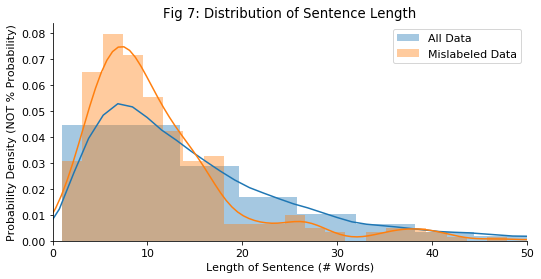

In [25]:
# Looking at sentence length of mis-classified quotes to see if we can gain any insights.
plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(figsize=(8.5,4))
sns.distplot(df['sentence_length'], bins = 30, label = 'All Data')
sns.distplot(df_incorrect['sentence_length'], bins = 30, label = 'Mislabeled Data')
axes.set_xlim(0,50)
axes.set_xlabel('Length of Sentence (# Words)')
axes.set_ylabel('Probability Density (NOT % Probability)')
axes.set_title('Fig 7: Distribution of Sentence Length')
leg = axes.legend()
sns.despine()

In [31]:
# Looking at short mis-classified quotes to see if we can gain any insights.
pd.set_option('display.max_rows', None)
df_incorrect[df_incorrect['sentence_length'] < 12][['Quote','Author','words']]

,Quote,Author,words
4103,did i mention i'm resigning?”,JK Rowling,"['did', 'i', 'mention', 'i', 'resigning']"
2208,“i do not know where the error lies.,Jane Austen,"['i', 'do', 'not', 'know', 'where', 'the'..."
7841,“the singing grew louder as they approached th...,JK Rowling,"['the', 'singing', 'grew', 'louder', 'as',..."
564,oh!,Jane Austen,['oh']
7632,“poverty entails fear and stress and sometimes...,JK Rowling,"['poverty', 'entails', 'fear', 'and', 'str..."
233,"“indeed, i am very sorry to be right in this i...",Jane Austen,"['indeed', 'i', 'am', 'very', 'sorry', 't..."
3116,it is a very nice word indeed!,Jane Austen,"['it', 'is', 'a', 'very', 'nice', 'word',..."
2353,“i do not understand you.”,Jane Austen,"['i', 'do', 'not', 'understand', 'you']"
5457,"he only meant to maim, or seriously injure.”",JK Rowling,"['he', 'only', 'meant', 'to', 'maim', 'or..."
3383,i am glad he dines here on tuesday.,Jane Austen,"['i', 'am', 'glad', 'he', 'dines', 'here'..."


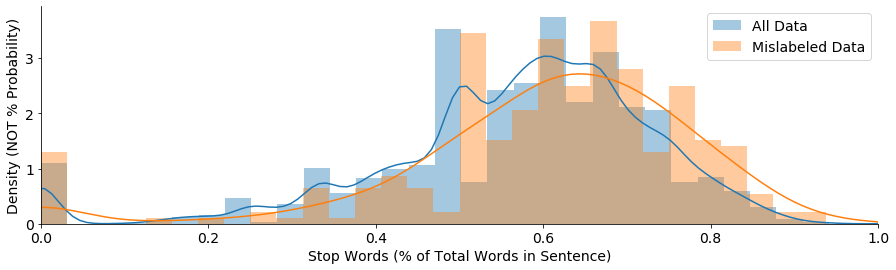

In [77]:
# Looking at stop word count of mis-classified quotes to see if we can gain any insights.
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(figsize=(15,4))
sns.distplot(df['stop_word_pct'], bins = 30, label = 'All Data')
sns.distplot(df_incorrect['stop_word_pct'], bins = 30, label = 'Mislabeled Data')
axes.set_xlim(0,1)
axes.set_xlabel('Stop Words (% of Total Words in Sentence)')
axes.set_ylabel('Density (NOT % Probability)')
leg = axes.legend()
sns.despine()